In [27]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait, Select
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager
import time
import pandas as pd

options = Options()
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')
options.add_argument('--disable-gpu')
# options.add_argument('--headless')  # 필요한 경우만 주석 해제

In [47]:
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)
url = 'https://eduinfo.go.kr/portal/theme/abolSchMapPage.do#none;'
driver.get(url)
driver.maximize_window()

wait = WebDriverWait(driver, 10)

# ✅ 시도 선택: '충청북도'
driver.find_element(By.XPATH, '//*[@id="contents"]/div[2]/div/div[1]/div[1]/select[1]').click()
driver.find_element(By.XPATH, '//*[@id="contents"]/div[2]/div/div[1]/div[1]/select[1]/option[12]').click()

# ✅ 학교명 검색창 요소 찾기
search_input = driver.find_element(By.XPATH, '//*[@id="contents"]/div[2]/div/div[1]/div[2]/input')

# ✅ 클릭 후 텍스트 입력
search_input.click()
search_input.clear()
search_input.send_keys('초')

driver.find_element(By.XPATH, '//*[@id="contents"]/div[2]/div/div[1]/div[2]/button').click()

In [48]:
xpaths = [
    '//*[@id="tbodyAppend"]/tr[1]/td[1]',
    '//*[@id="tbodyAppend"]/tr[2]/td[2]',
    '//*[@id="tbodyAppend"]/tr[4]/td[1]',
    '//*[@id="tbodyAppend"]/tr[4]/td[2]'
]

results = []

# ✅ 총 개수 확인
initial_items = driver.find_elements(By.XPATH, '//*[@id="schList"]/li')
total_schools = len(initial_items)

print(f"총 {total_schools}개의 학교 발견")

for i in range(1, total_schools+1):
    try:
        school_elem = driver.find_element(By.XPATH, f'//*[@id="schList"]/li[{i}]/a')
        school_name_elem = driver.find_element(By.XPATH, f'//*[@id="schList"]/li[{i}]/a/em')

        school_name = school_name_elem.text.strip()
        school_elem.click()


        # ✅ 데이터 수집
        data = {'학교명': school_name}
        for xpath in xpaths:
            try:
                element = driver.find_element(By.XPATH, xpath)
                text = element.text.strip()
                data[xpath] = text
            except:
                data[xpath] = ''

        results.append(data)
        time.sleep(2)

    except Exception as e:
        print(f"{i+1}번째 항목에서 오류 발생: {e}")
        continue

총 114개의 학교 발견


In [54]:
# ✅ 저장
df = pd.DataFrame(results)
rename_map = {
    '//*[@id="tbodyAppend"]/tr[1]/td[1]': '폐교연도',
    '//*[@id="tbodyAppend"]/tr[2]/td[2]': '활용현황',
    '//*[@id="tbodyAppend"]/tr[4]/td[1]': '활용계획',
    '//*[@id="tbodyAppend"]/tr[4]/td[2]': '대부내역'
}

df = df.rename(columns=rename_map)
df = df.sort_values('활용현황')
df.to_csv("충북_폐교_초등학교_상세정보.csv", index=False, encoding='utf-8-sig')

In [53]:
df.sort_values('활용현황')

,학교명,폐교연도,활용현황,활용계획,대부내역
0,(구)내북초,2013,대부,사회복지시설,내부 장애인재활교육장
60,어상천초 선암분교장,2001,대부,교육용시설,자연학습체험학교
59,어상천초 덕문곡분교장,1992,대부,소득증대시설,체험학습장
58,양화초,1995,대부,교육용시설,지적박물관
57,양산초천태분교장,1994,대부,교육용시설,"청소년 수련, 체험, 도서관"
...,...,...,...,...,...
3,(구)옥동초,2014,자체활용,충청북도국제교육원 중부분원,
84,칠성초 쌍곡분교장,1991,자체활용,교직원휴양소,
24,대소원초,2020,자체활용,(가칭)중ㆍ북부교육시설복합센터,
87,현암초,1999,자체활용,충북학생롤러경기장,


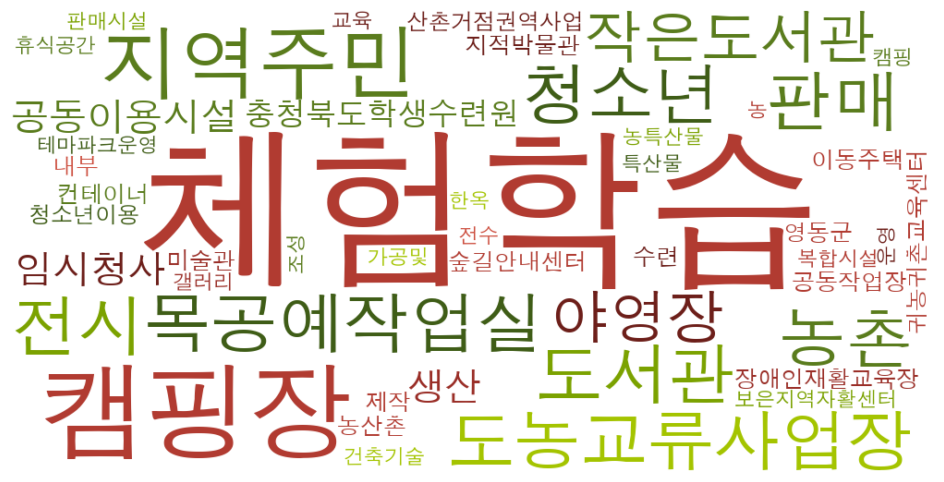

In [82]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re
import matplotlib.font_manager as fm
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import random

# ✅ 원하는 색상 리스트
custom_colors = [
    '#a4c400',  # 딥라임
    '#7ba200',  # 올리브그린 계열
    '#5a7c1d',  # 짙은 녹색
    '#3f5d17',  # 어두운 녹색
    '#cc4c3c',  # 진한 코랄
    '#b13b31',  # 벽돌색 느낌
    '#9a2e27',  # 다크 레드브라운
    '#6d1f1a'   # 거의 밤색
]

# ✅ 색상 지정 함수
def custom_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return random.choice(custom_colors)

plt.rcParams['font.family'] = 'AppleGothic'


# ✅ 데이터 불러오기
df = pd.read_csv("충북_폐교_초등학교_상세정보.csv")

# ✅ 텍스트 정제 함수 정의
def replace_cheheom(text):
    # '체험'이 포함된 단어들을 모두 '체험학습'으로 대체
    return re.sub(r'\b\w*체험\w*\b', '체험학습', text)

# ✅ 텍스트 전처리 적용
text_대부 = replace_cheheom(' '.join(df[df['활용현황'] == '대부']['대부내역'].dropna().astype(str)))
text_자체 = replace_cheheom(' '.join(df[df['활용현황'] == '자체활용']['활용계획'].dropna().astype(str)))

# ✅ 결합
combined_text = text_대부 + ' ' + text_자체

# ✅ 워드클라우드 생성
# ✅ 기본 불용어에 '및' 추가
custom_stopwords = set(STOPWORDS)
custom_stopwords.add('및')
custom_stopwords.add('소득증대시설')

# ✅ 워드클라우드 생성
wc = WordCloud(
    font_path='/System/Library/Fonts/AppleGothic.ttf',  # macOS 기준
    width=1000,
    height=500,
    background_color='white',
    color_func=custom_color_func,
    # colormap='Set1',
    max_words=100,
    stopwords=custom_stopwords,  # 불용어 설정!
    min_font_size=20,          # ✅ 최소 글씨 크기 설정
).generate(combined_text)

# ✅ 시각화
plt.figure(figsize=(12, 6))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()